<a href="https://colab.research.google.com/github/kalakhushi18/Deep-Learning/blob/main/ExtremeValueTheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extreme Value Theory (EVT) deals with the extreme, rare events—either the largest or smallest values—in a dataset. Instead of analyzing the whole dataset, EVT zooms in on the most extreme outcomes to understand their behavior and predict how often such events might occur.

Examples: Predicting  floods, stock market crashes

In [1]:
!pip install pyextremes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.7 MB/s eta 0:00:00


In [2]:
import pandas as pd

from pyextremes import __version__, get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import EVA
print("pyextremes", __version__)

pyextremes 2.3.3


# Load Data

In [3]:
url = 'https://raw.githubusercontent.com/kboroz/TimeSeriesPrediction/refs/heads/main/Data/battery_wl.csv'

import pandas as pd

series = pd.read_csv(
    url,
    index_col=0,
    parse_dates=True,
).squeeze()


In [4]:
# Looking data
series

,Water Elevation [m NAVD88]
Date-Time (GMT),
1920-06-01 05:00:00,-0.659
1920-06-01 06:00:00,-0.873
1920-06-01 07:00:00,-1.025
1920-06-01 08:00:00,-0.964
1920-06-01 09:00:00,-0.659
...,...
2020-03-31 19:00:00,0.644
2020-03-31 20:00:00,0.498
2020-03-31 21:00:00,0.253


In [8]:
# checking the date range

print("The first date: ",series.index.min() )
print("The last date: ", series.index.max())


The first date:  1920-06-01 05:00:00
The last date:  2020-03-31 23:00:00


# Clean up data

In order for the analysis results to be meaningful, data needs to be pre-processed by the user. This may include removal of data gaps, detrending, interpolation, removal of outliers, etc. Let's clean up the data:

In [11]:
pd.to_timedelta("365.2425D")

Timedelta('365 days 05:49:12')

In [10]:
series.index.array - pd.to_datetime("1992")

<TimedeltaArray>
['-26146 days +05:00:00', '-26146 days +06:00:00', '-26146 days +07:00:00',
 '-26146 days +08:00:00', '-26146 days +09:00:00', '-26146 days +10:00:00',
 '-26146 days +11:00:00', '-26146 days +12:00:00', '-26146 days +13:00:00',
 '-26146 days +14:00:00',
 ...
   '10317 days 14:00:00',   '10317 days 15:00:00',   '10317 days 16:00:00',
   '10317 days 17:00:00',   '10317 days 18:00:00',   '10317 days 19:00:00',
   '10317 days 20:00:00',   '10317 days 21:00:00',   '10317 days 22:00:00',
   '10317 days 23:00:00']
Length: 809903, dtype: timedelta64[ns]

In [12]:
# adjusts the series based on a time-dependent trend

series = (
    series
    .sort_index(ascending=True)
    .astype(float)
    .dropna()
    .loc[pd.to_datetime("1925"):]
)

# standardizing the data to a reference date and scaling it
series = series - (series.index.array - pd.to_datetime("1992")) / pd.to_timedelta("365.2425D") * 2.87e-3


In [13]:
#looking data after cleaning
series

,Water Elevation [m NAVD88]
Date-Time (GMT),
1926-11-20 05:00:00,-0.411120
1926-11-20 06:00:00,-0.777120
1926-11-20 07:00:00,-1.051120
1926-11-20 08:00:00,-1.051121
1926-11-20 09:00:00,-0.808121
...,...
2020-03-31 19:00:00,0.562925
2020-03-31 20:00:00,0.416925
2020-03-31 21:00:00,0.171924


# Create model

The primary interface to the pyextremes library is provided via the EVA class. This class is responsible for all major tasks outlined above and is created using a simple command:

In [14]:
# Extreme Value Analysis (EVA) class

from pyextremes import EVA

model = EVA(series)


In [15]:
# Block Maxima
model.get_extremes(method="BM", block_size="365.2425D")

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

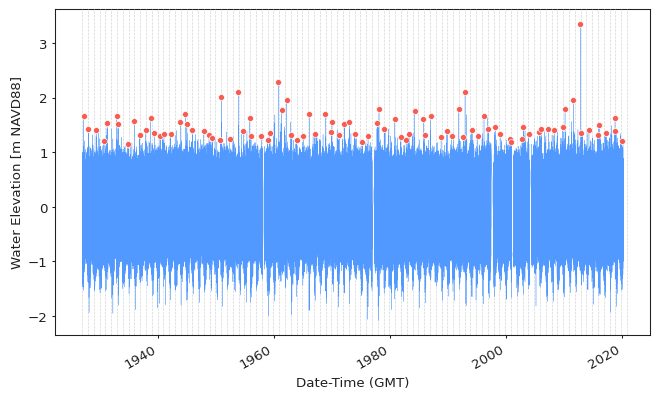

In [16]:
model.plot_extremes()

In [18]:
#  Maximum Likelihood Estimate (MLE) model
model.fit_model()

# Calculate return values

The final goal of most EVA's is estimation of return values. The simplest way to do this is by using the get_summary method:

In Extreme Value Analysis (EVA), return values are estimates of the magnitude of an extreme event that is expected to occur (or be exceeded) on average once within a given time period. These values are often associated with return periods.

In [19]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],  #yearly by default
    alpha=0.95,  # Width of confidence interval
    n_samples=1000,  # bootstrap samples
)

In [21]:
# returning lower confidence interval, upper confidence interval
# the true value of the estimated parameter lies within the calculated interval.
print(summary)

               return value  lower ci  upper ci
return period                                  
1.0                0.802610 -0.317269  1.033216
2.0                1.409343  1.369657  1.453232
5.0                1.622565  1.550992  1.701050
10.0               1.803499  1.681906  1.947795
25.0               2.090267  1.861605  2.403595
50.0               2.354889  2.004621  2.864875
100.0              2.671313  2.150293  3.493384
250.0              3.188356  2.344110  4.709081
500.0              3.671580  2.523056  6.011844
1000.0             4.252220  2.724216  7.771101


# Investigate model

After model results are obtained, logical questions naturally arise - how good is the model, are the obtained results meaningful, and how confident can I be with the estimated return values. One way to do that is by visually inspecting the model:

EVT describes extremes using three "limiting distributions": Gumbel, Fréchet, and Weibull.
The Weibull case applies when the underlying data is bounded above or below, meaning there is a limit beyond which extreme values cannot occur.

The Weibull theorem fits into EVT as a limiting distribution of block minima or maxima, helping researchers quantify and predict bounded extreme events within a dataset.

The Gumbel distribution models the behavior of the most extreme values (largest or smallest) in datasets where the extreme events are unbounded.

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='Water Elevation [m NAVD88]'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='Water Elevation [m NAVD88]', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

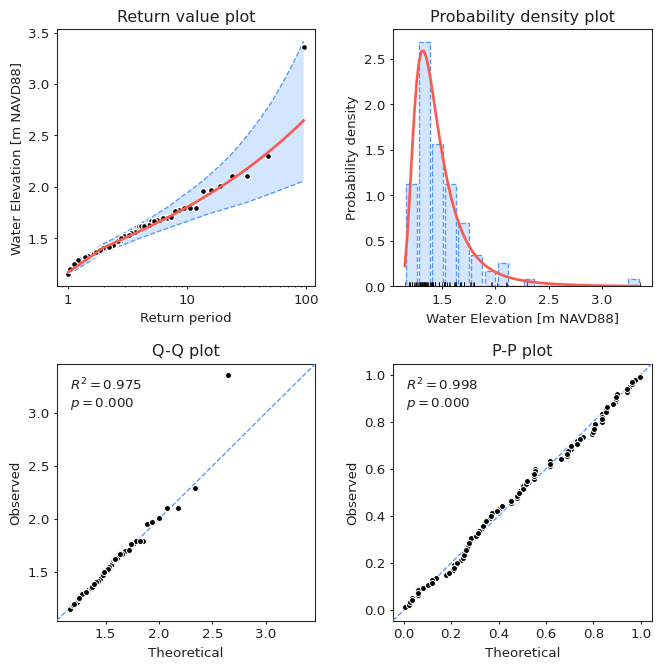

In [22]:
model.plot_diagnostic(alpha=0.95)

# Block Maxima

Block Maxima or Minima (BM) extreme values are extracted from time series by partitioning it into blocks (segments) of equal duration (e.g. 1 year) and locating maximum or minimum values within each block. Block maxima extreme values asymptotically follow the Generalized Extreme Value Distribution family, according to the Fisher–Tippett–Gnedenko theorem. This theorem demonstrates that the GEVD family is the only possible limit for the block maxima extreme values.

 the block maxima from sufficiently large blocks converge to the Generalized Extreme Value (GEV) distribution, making it ideal for predicting return levels and probabilities of future extreme events.

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

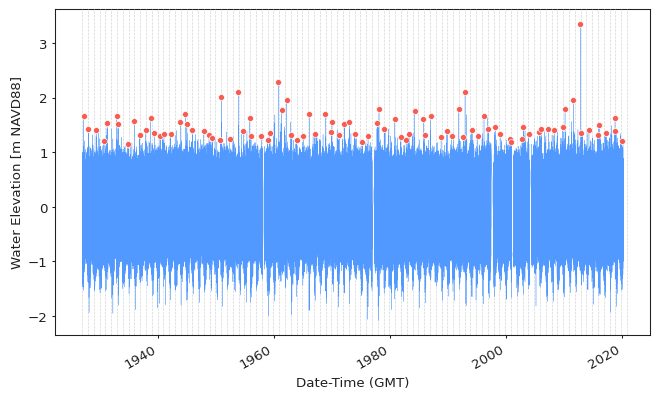

In [23]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes

extremes = get_extremes(series, "BM")
plot_extremes(
    ts=series,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
)

# Extracting Extremes

As outlined in the Read First section of this documentation, there are multiple ways the same thing can be achieved in pyextremes. The BM extraction function can be accessed via:

    pyextremes.extremes.block_maxima.get_extremes_block_maxima - the lowest level
    pyextremes.get_extremes - general-purpose extreme value extraction function
    pyextremes.EVA.get_extremes - helper-class (extreme values are not returned by this function, but instead are set on the EVA instance in the .extremes attribute)

The simplest way to extract extreme values using BM method is to use the default parameters of the get_extremes function:

In [24]:
get_extremes(
    ts=series,
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=None,
)

,Water Elevation [m NAVD88]
Date-Time (GMT),
1927-02-20 16:00:00,1.670154
1927-12-05 10:00:00,1.432893
1929-04-16 19:00:00,1.409977
1930-08-23 01:00:00,1.202101
1931-03-08 17:00:00,1.529547
...,...
2016-02-09 14:00:00,1.498808
2017-03-14 15:00:00,1.362672
2018-10-27 15:00:00,1.623020


# Selecting Block Size

Like with most choices in statistics, selection of block size involves making a trade-off between bias and variance: blocks that are too small mean that approximation by the limit model (GEVD) is likely to be poor, leading to bias in estimation and extrapolation; large blocks generate few block maxima/minima, leading to large estimation variance. Pragmatic considerations often lead to the adoption of blocks of length one year. (Coles, 2004)

An important thing to consider is also the physical nature of investigated signal. Many meteorological events (e.g. snowfall, rain, waves) are seasonal and, therefore, selection of block sizes smaller than 1-year would result in significant bias due to blocks no longer being equivalent (e.g. summer blocks are nearly guaranteed to have no snow).

We can specify different block size using the block_size argument. Using the same data as above but with a block size of 2 years we get:

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

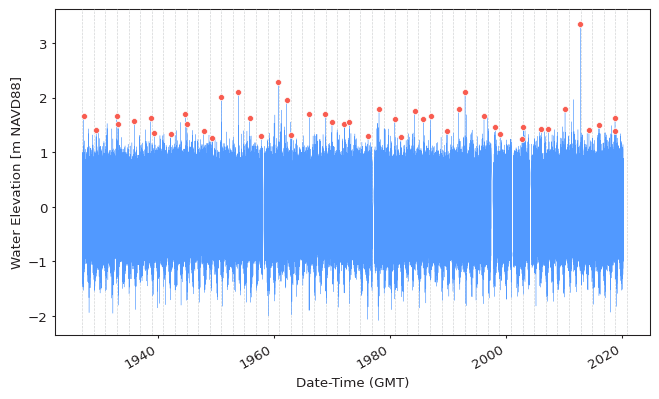

In [25]:
extremes = get_extremes(
    ts=series,
    method="BM",
    block_size=pd.to_timedelta("365.2425D") * 2,
)
plot_extremes(
    ts=series,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size=pd.to_timedelta("365.2425D") * 2,
)

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

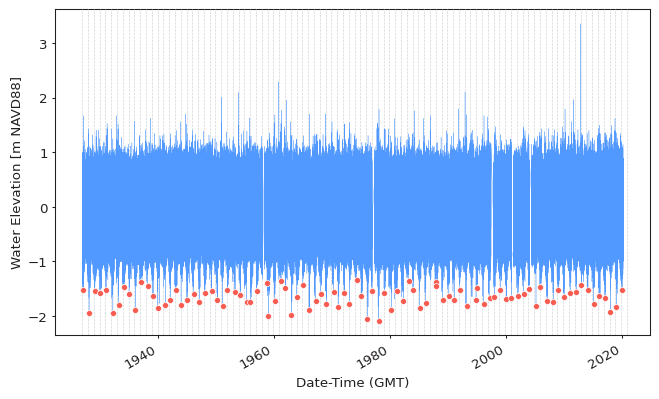

In [27]:
extremes = get_extremes(
    ts=series,
    method="BM",
    extremes_type="low",
)
plot_extremes(
    ts=series,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="low",
    block_size="365.2425D",
)

# Peaks Over Threshold

Peaks Over Threshold (POT) extreme values are extracted from time series by first generating a time series of exceedances by selecting values above (or below for extremes_type="low") a certain threshold and then declustering the exceedance time series by identifying clusters separated by a given time period and then selecting only the highest (lowest) values within each cluster. Declustering is performed in order to ensure that these values are IID (independent and identically distributed) which is required for the corresponding limit distribution to be applicable. The POT extreme values asymptotically follow the Generalized Pareto Distribution famliy, according to the Pickands–Balkema–De Haan theorem.

Threshold:

This is the value above which data points are considered "extreme."
Choosing the right threshold is critical:
Too low → Includes non-extreme events, distorting results.
Too high → Misses important data, leading to less reliable analysis.
Exceedance:

A data point that is greater than the threshold.(520- 500 = 20)


Generalized Pareto Distribution (GPD):

A mathematical model used to describe the exceedances.
Helps estimate probabilities of future extreme events or calculate return levels.

/usr/local/lib/python3.10/dist-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/usr/local/lib/python3.10/dist-packages/pyextremes/eva.py:525: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  self.__extremes_kwargs["r"] = pd.to_timedelta(kwargs.get("r", "24h"))


(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

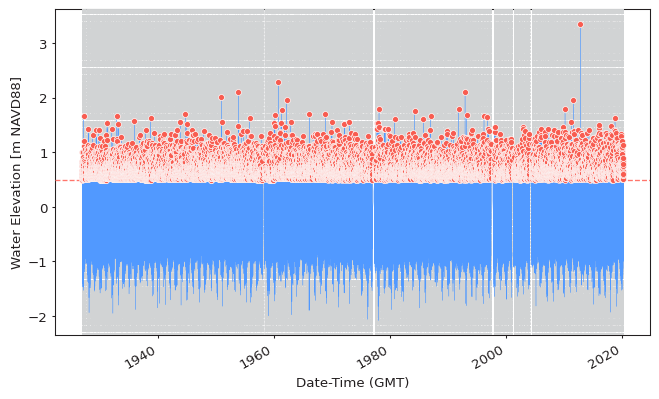

In [28]:
from pyextremes import EVA

model = EVA(data=series)
model.get_extremes("POT", threshold=0.5, r="12H")
model.plot_extremes(show_clusters=True)

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

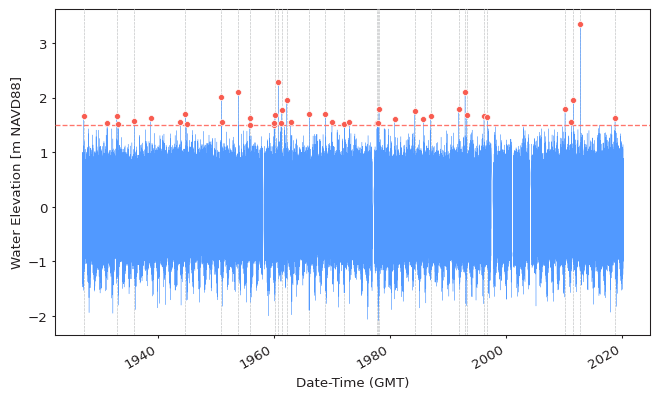

In [ ]:
from pyextremes import EVA

model = EVA(data=series)
model.get_extremes("POT", threshold=1.5, r="12H")
model.plot_extremes(show_clusters=True)

## Declustering

As described earlier, declustering is controlled using the r argument. The goal of declustering is to ensure that all extreme values are IID, which is a requirement for the GPD model to be valid. Shown below is an example of extremes extracted from the same data and using the same threshold as above, but with a larger r value

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

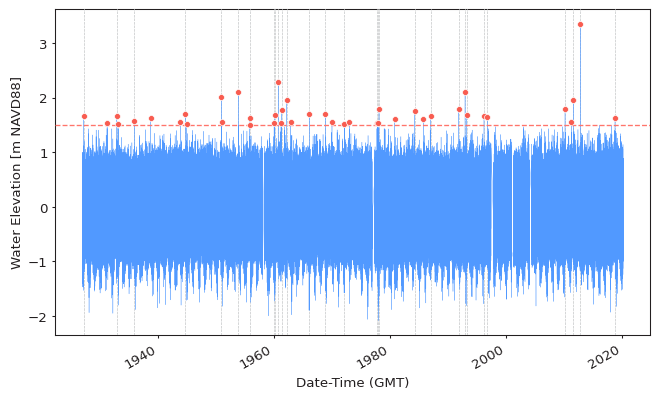

In [ ]:
model = EVA(data=series)
model.get_extremes("POT", threshold=1.5, r="24H")
model.plot_extremes(show_clusters=True)

# Threshold Selection

Selection of the threshold value is a very important step because it has the strongest effect on the results of EVA. The core idea of threshold selection is the same as when selecting block size in the Block Maxima approach - it is a trade-off between bias and variance. Larger threshold values produce few extreme values and lead to large variance in result (confidence bounds), while smaller threshold values generate a sample which poorly approximates the GPD model. The opposite is true when performing EVA for extreme low values (extremes_type="low").

#The key goal of threshold selection can, therefore, be formulated as follows:


Select the smallest threshold value among those which produce extreme values following the limit exceedance model (Generalized Pareto Distribution family).

 This process ensures that the threshold is set high enough to capture only the extreme events but not so high that there are too few data points to make reliable statistical estimates.

#Warning

Threshold selection is probably the hardest part of Extreme Value Analysis when analyzing extreme values obtained using the Peaks Over Threshold method. It involves a great deal of subjective judgement and should be performed in conjunction with other methods, such as Block Maxima + GEVD, to gain more confidence in the validty of obtained results.


# Mean Residual Life

Mean residual life plot plots average excess value over given threshold for a series of thresholds. The idea is that the mean residual life plot should be approximately linear above a threshold for which the Generalized Pareto Distribution model is valid.

<Axes: xlabel='Threshold', ylabel='Mean excess'>

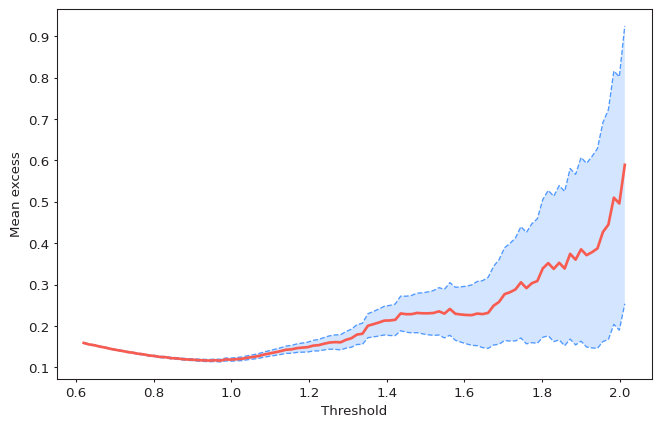

In [29]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(series)

As seen in the figure above, exceedance values are approximately linear between threshold values of 1.2 and 1.8. This provides a range of threshold values which can be further investigated using other methods.

The plot_mean_residual_life function uses the following parameters:

    ts - time series (pandas.Series) from which the extreme values are extracted
    thresholds - array of threshold for which the plot is displayed. By default 100 equally-spaced thresholds between 90th (10th if extremes_type="high") percentile and 10th largest (smallest if extremes_type="low") value in the series.
    extremes_type - extreme value type: "high" for above threshold (default) and "low" for below threshold.
    alpha - confidence interval width in the range (0, 1), by default it is 0.95. If None, then confidence interval is not shown.
    ax - matplotlib Axes object. If provided, then the plot is drawn on this axes. If None (default), new figure and axes are created
    figsize - figure size in inches in format (width, height). By default it is (8, 5).


# Parameter Stability

Parameter stability plot shows how shape and modified scale parameters of the Generalized Pareto Distribution change over a range of threshold values. The idea is that these parameters should be stable (vary by small amount) within a range of valid thresholds.

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

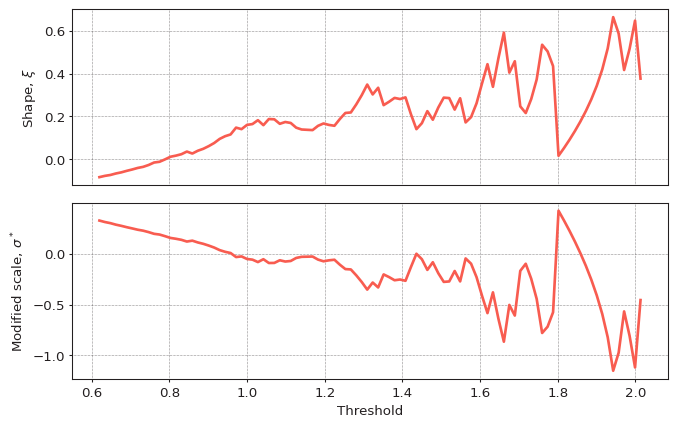

In [30]:
from pyextremes import plot_parameter_stability

plot_parameter_stability(series)

As seen in the figure above, these parameters appear to stabilize around threshold value of 1.2 with subsequent values having higher variance due to smaller number of exceedances.

In [31]:
!pip install evt

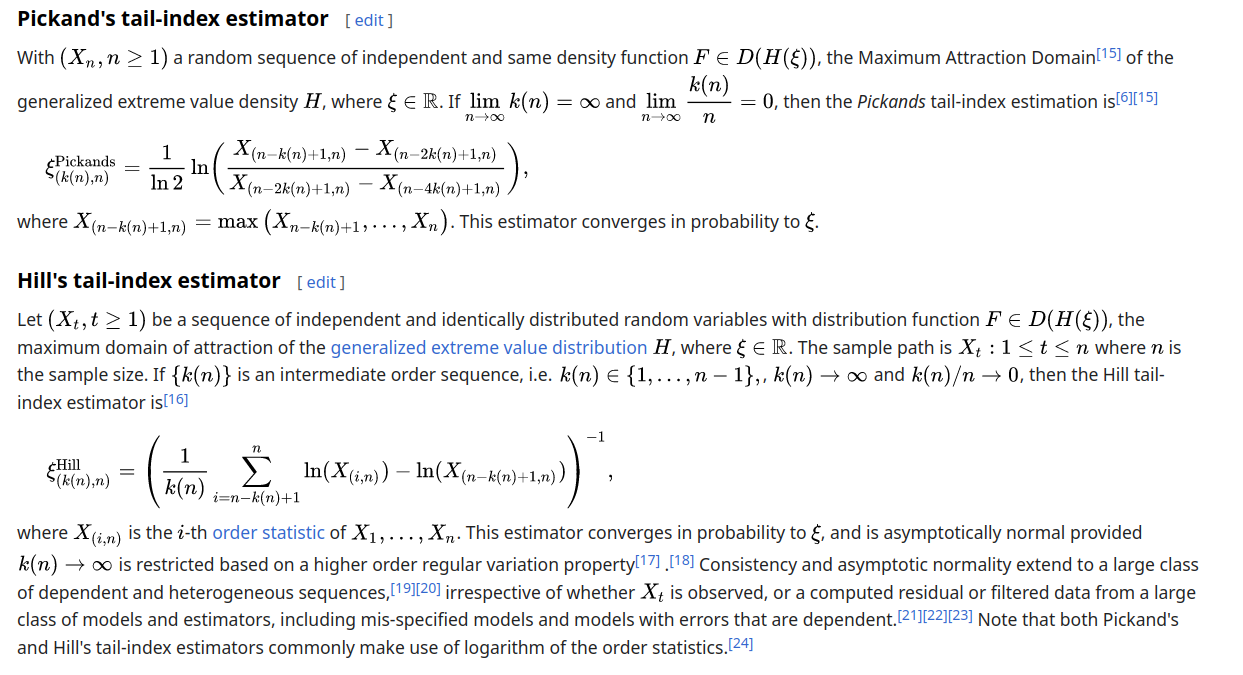

In [32]:
from evt.dataset import Dataset
from evt.methods.peaks_over_threshold import PeaksOverThreshold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pareto, norm

THRESHOLD = 1.5  # threshold in the peaks over threshold method
EXAMPLE_NAME = 'Values'  # for nicer plots
EXAMPLE_INDEX_NAME = 'Index'

np.random.seed(0)  # enforce deterministic behaviour

dataset = Dataset(series)

peaks_over_threshold = PeaksOverThreshold(dataset, THRESHOLD)

In [33]:
from evt.estimators.hill import Hill

hill = Hill(peaks_over_threshold)

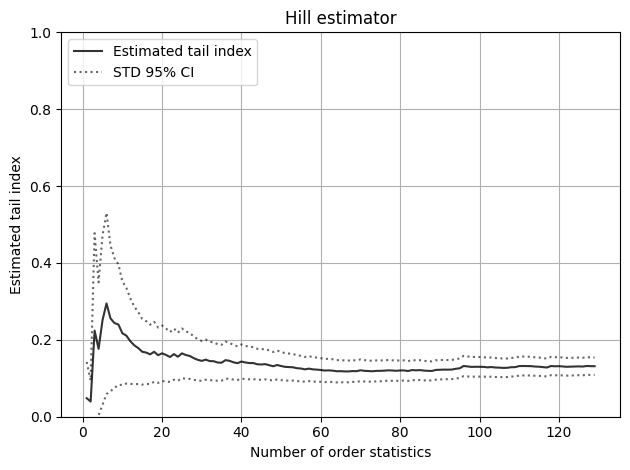

In [34]:
fig, ax = plt.subplots()

hill.plot(ax)

ax.set_ylim(0, 1)  # zoom
fig.tight_layout()
plt.show()

# Return Value Stability

An extension of the previous technique is to investigate stability of a target return value with a pre-defined return period over a range of thresholds. This technique provides a more intuitive metric of model stability. Let's plot it for the range of thresholds identified earlier:

<Axes: xlabel='Threshold', ylabel='Return value'>

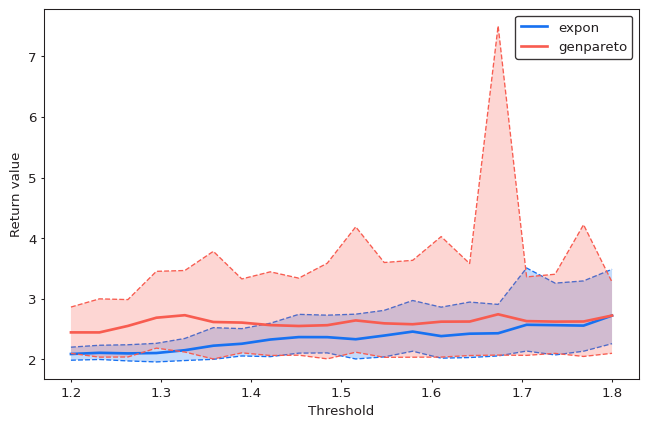

In [35]:
import numpy as np

from pyextremes import plot_return_value_stability

plot_return_value_stability(
    series,
    return_period=100,
    thresholds=np.linspace(1.2, 1.8, 20),
    alpha=0.95,
)

As seen in the figure above, the model is very stable for threshold values above 1.4.